# 03 - Model Training: Computer Price Prediction

This notebook trains and evaluates models to predict computer prices.

**Data is pre-processed in notebook 02 with:**
- Features with >60% missing values removed
- CPU/GPU matching with close neighbor and family mean imputation
- Complete benchmark features: mark, rank, value, price for both CPU and GPU
- Target leakage columns excluded (cpu_match_score, gpu_match_score, Ofertas)

**Models compared:**
1. Baseline (DummyRegressor - predicts mean)
2. Ridge Regression (L2 regularization)
3. RandomForestRegressor
4. HistGradientBoostingRegressor
5. CatBoostRegressor (with native categorical handling)
6. CatBoost Quantile models (for price range prediction)

**Metrics (in order of importance):**
- **MAE** (primary) - Mean Absolute Error, robust to outliers
- RMSE - Root Mean Squared Error
- R² - Coefficient of determination
- MAPE - Mean Absolute Percentage Error

---

## 1. Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
from pathlib import Path

# Add src to path
sys.path.append('..')

# Reload modules
for mod in ['src.modeling', 'modeling', 'src.features', 'features']:
    if mod in sys.modules:
        del sys.modules[mod]

from src.modeling import (
    infer_feature_types,
    get_feature_summary,
    build_sklearn_pipeline,
    build_catboost_model,
    prepare_catboost_data,
    evaluate_sklearn_cv,
    evaluate_predictions,
    compare_models,
    save_model,
    load_features_data,
    CATBOOST_AVAILABLE
)

from src.features import get_feature_columns

from sklearn.model_selection import train_test_split

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style='whitegrid')
warnings.filterwarnings('ignore')

print("Libraries loaded!")
print(f"CatBoost available: {CATBOOST_AVAILABLE}")

Libraries loaded!
CatBoost available: True


## 2. Load Pre-Processed Data

Data has been prepared in notebook 02:
- Rows without target removed
- Features with >60% missing values removed
- Only engineered features (starting with _) included

In [2]:
DATA_DIR = Path('../data')

# Try to load parquet, fall back to CSV
try:
    df = pd.read_parquet(DATA_DIR / 'db_features.parquet')
    print("Loaded from parquet")
except (ImportError, FileNotFoundError):
    df = pd.read_csv(DATA_DIR / 'db_features.csv')
    print("Loaded from CSV")

print(f"\nDataset shape: {df.shape}")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

Loaded from CSV

Dataset shape: (7767, 63)
Rows: 7,767
Columns: 63


In [3]:
# Check target variable
TARGET_COL = '_precio_num'

print(f"Target: {TARGET_COL}")
print(f"  Non-null: {df[TARGET_COL].notna().sum():,}")
print(f"  Min: {df[TARGET_COL].min():,.2f}")
print(f"  Max: {df[TARGET_COL].max():,.2f}")
print(f"  Mean: {df[TARGET_COL].mean():,.2f}")
print(f"  Median: {df[TARGET_COL].median():,.2f}")

Target: _precio_num
  Non-null: 7,767
  Min: 222.50
  Max: 6,070.15
  Mean: 1,455.98
  Median: 1,184.95


## 3. Prepare Features

Use pre-computed feature types from the features module.

In [4]:
# Get feature types (data is already prepared in notebook 02)
feature_cols, numeric_cols, categorical_cols = get_feature_columns(df, TARGET_COL)

print(f"Total features: {len(feature_cols)}")
print(f"  Numeric: {len(numeric_cols)}")
print(f"  Categorical: {len(categorical_cols)}")

print(f"\nNumeric features: {numeric_cols}")
print(f"Categorical features: {categorical_cols}")

Total features: 62
  Numeric: 20
  Categorical: 42

Numeric features: ['_resolucion_pixeles', '_gpu_value', '_gpu_price_usd', 'Otras características_Fecha de lanzamiento', '_tiene_webcam', '_tamano_pantalla_pulgadas', '_version_bluetooth', '_peso_kg', '_cpu_price_usd', '_cpu_value', 'Disco duro_Número de discos duros (instalados)', '_cpu_cores', '_gpu_rank', '_gpu_mark', '_ssd_gb', '_ram_gb', '_cpu_mark', '_cpu_rank', '_tiene_bluetooth', '_tiene_wifi']
Categorical features: ['Pantalla_Resolución de pantalla', 'Comunicaciones_Estándar LAN', 'Sistema operativo_Arquitectura bit', 'Alimentación_Vatios-hora', 'gpu_series', 'Pantalla_Formato de imagen', 'Medidas y peso_Diseño', 'Cámara_Webcam', 'Comunicaciones_Estándar wifi', 'Medidas y peso_Altura', 'Pantalla_Diagonal de la pantalla', 'Pantalla_Tamaño de la pantalla', 'Almacenamiento_Lector óptico', 'Comunicaciones_Versión Bluetooth', 'Medidas y peso_Peso', '_serie', 'Procesador_Frecuencia de reloj', 'Procesador_Nombre en clave del procesad

In [5]:
# Show feature summary
summary = get_feature_summary(df, numeric_cols, categorical_cols)

print("=== Numeric Features ===")
display(summary[summary['type'] == 'numeric'].head(20))

print("\n=== Categorical Features (sample) ===")
display(summary[summary['type'] == 'categorical'].head(20))

=== Numeric Features ===


,column,type,dtype,non_null,null_pct,unique,min,max
42,Disco duro_Número de discos duros (instalados),numeric,float64,5391,30.59,4,0.00,3.00
43,Otras características_Fecha de lanzamiento,numeric,float64,3622,53.37,13,2013.00,2025.00
44,_cpu_cores,numeric,float64,6285,19.08,13,1.00,24.00
45,_cpu_mark,numeric,float64,6715,13.54,402,864.00,70401.00
46,_cpu_price_usd,numeric,float64,5231,32.65,194,29.99,1299.00
47,_cpu_rank,numeric,float64,6715,13.54,405,73.00,4174.00
48,_cpu_value,numeric,float64,5231,32.65,252,4.98,264.58
49,_gpu_mark,numeric,float64,6422,17.32,105,39.00,39850.00
50,_gpu_price_usd,numeric,float64,3547,54.33,47,76.00,4109.99
51,_gpu_rank,numeric,float64,6422,17.32,105,1.00,2418.00



=== Categorical Features (sample) ===


,column,type,dtype,non_null,null_pct,unique,min,max
0,Alimentación_Vatios-hora,categorical,object,3530,54.55,90,NaN,NaN
1,Almacenamiento_Lector óptico,categorical,object,3872,50.15,3,NaN,NaN
2,Comunicaciones_Conectividad,categorical,object,7419,4.48,27,NaN,NaN
3,Comunicaciones_Estándar LAN,categorical,object,3249,58.17,6,NaN,NaN
4,Comunicaciones_Estándar wifi,categorical,object,3772,51.44,8,NaN,NaN
5,Comunicaciones_Versión Bluetooth,categorical,object,4743,38.93,8,NaN,NaN
6,Cámara_Webcam,categorical,object,3716,52.16,20,NaN,NaN
7,Disco duro_Capacidad de memoria SSD,categorical,object,6436,17.14,21,NaN,NaN
8,Disco duro_Tipo de disco duro,categorical,object,5732,26.20,10,NaN,NaN
9,Gráfica_Memoria gráfica,categorical,object,6125,21.14,52,NaN,NaN


In [6]:
# Prepare X and y (data is already cleaned, no need to filter)
X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

print(f"Training data shape: X={X.shape}, y={y.shape}")

Training data shape: X=(7767, 62), y=(7767,)


In [7]:
# Train/test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

Train: 6,213 samples
Test: 1,554 samples


## 4. Train and Evaluate Models

We'll train multiple models and compare their performance using cross-validation.

In [8]:
# Dictionary to store results
all_results = {}

### 4.1 Baseline Model (DummyRegressor)

In [9]:
print("=" * 60)
print("BASELINE MODEL (Predict Mean)")
print("=" * 60)

baseline_pipeline = build_sklearn_pipeline('dummy', numeric_cols, categorical_cols)
baseline_results = evaluate_sklearn_cv(baseline_pipeline, X_train, y_train, cv=5)

all_results['Baseline (Mean)'] = baseline_results

print(f"\nCross-Validation Results:")
print(f"  RMSE: {baseline_results['rmse_mean']:,.2f} (+/- {baseline_results['rmse_std']:,.2f})")
print(f"  MAE:  {baseline_results['mae_mean']:,.2f} (+/- {baseline_results['mae_std']:,.2f})")
print(f"  R²:   {baseline_results['r2_mean']:.4f} (+/- {baseline_results['r2_std']:.4f})")

BASELINE MODEL (Predict Mean)

Cross-Validation Results:
  RMSE: 996.36 (+/- 25.83)
  MAE:  748.49 (+/- 10.97)
  R²:   -0.0005 (+/- 0.0004)


### 4.2 Ridge Regression

In [10]:
print("=" * 60)
print("RIDGE REGRESSION")
print("=" * 60)

ridge_pipeline = build_sklearn_pipeline('ridge', numeric_cols, categorical_cols)
ridge_results = evaluate_sklearn_cv(ridge_pipeline, X_train, y_train, cv=5)

all_results['Ridge'] = ridge_results

print(f"\nCross-Validation Results:")
print(f"  RMSE: {ridge_results['rmse_mean']:,.2f} (+/- {ridge_results['rmse_std']:,.2f})")
print(f"  MAE:  {ridge_results['mae_mean']:,.2f} (+/- {ridge_results['mae_std']:,.2f})")
print(f"  R²:   {ridge_results['r2_mean']:.4f} (+/- {ridge_results['r2_std']:.4f})")

RIDGE REGRESSION

Cross-Validation Results:
  RMSE: 495.60 (+/- 18.45)
  MAE:  320.69 (+/- 8.23)
  R²:   0.7522 (+/- 0.0145)


### 4.3 Random Forest

In [11]:
print("=" * 60)
print("RANDOM FOREST")
print("=" * 60)

rf_pipeline = build_sklearn_pipeline('random_forest', numeric_cols, categorical_cols)
rf_results = evaluate_sklearn_cv(rf_pipeline, X_train, y_train, cv=5)

all_results['Random Forest'] = rf_results

print(f"\nCross-Validation Results:")
print(f"  RMSE: {rf_results['rmse_mean']:,.2f} (+/- {rf_results['rmse_std']:,.2f})")
print(f"  MAE:  {rf_results['mae_mean']:,.2f} (+/- {rf_results['mae_std']:,.2f})")
print(f"  R²:   {rf_results['r2_mean']:.4f} (+/- {rf_results['r2_std']:.4f})")

RANDOM FOREST

Cross-Validation Results:
  RMSE: 503.61 (+/- 17.86)
  MAE:  302.01 (+/- 8.46)
  R²:   0.7443 (+/- 0.0114)


### 4.4 HistGradientBoosting

In [12]:
print("=" * 60)
print("HIST GRADIENT BOOSTING")
print("=" * 60)

hgb_pipeline = build_sklearn_pipeline('hist_gradient_boosting', numeric_cols, categorical_cols)
hgb_results = evaluate_sklearn_cv(hgb_pipeline, X_train, y_train, cv=5)

all_results['HistGradientBoosting'] = hgb_results

print(f"\nCross-Validation Results:")
print(f"  RMSE: {hgb_results['rmse_mean']:,.2f} (+/- {hgb_results['rmse_std']:,.2f})")
print(f"  MAE:  {hgb_results['mae_mean']:,.2f} (+/- {hgb_results['mae_std']:,.2f})")
print(f"  R²:   {hgb_results['r2_mean']:.4f} (+/- {hgb_results['r2_std']:.4f})")

HIST GRADIENT BOOSTING

Cross-Validation Results:
  RMSE: 480.62 (+/- 18.15)
  MAE:  297.20 (+/- 10.92)
  R²:   0.7671 (+/- 0.0105)


### 4.5 CatBoost (if available)

In [13]:
if CATBOOST_AVAILABLE:
    from sklearn.model_selection import cross_val_score
    from catboost import CatBoostRegressor
    
    print("=" * 60)
    print("CATBOOST")
    print("=" * 60)
    
    # Prepare data for CatBoost (data is already cleaned from notebook 02)
    X_cb, y_cb = prepare_catboost_data(
        df.copy(),
        numeric_cols,
        categorical_cols,
        TARGET_COL
    )
    
    X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(
        X_cb, y_cb, test_size=0.2, random_state=42
    )
    
    # Build CatBoost model with MAE loss (primary metric)
    cat_model = build_catboost_model(categorical_cols, loss_function='MAE')
    
    # Cross-validation using sklearn - MAE first (primary)
    neg_mae_scores = cross_val_score(
        cat_model, X_cb_train, y_cb_train,
        cv=5, scoring='neg_mean_absolute_error'
    )
    neg_rmse_scores = cross_val_score(
        cat_model, X_cb_train, y_cb_train, 
        cv=5, scoring='neg_root_mean_squared_error'
    )
    r2_scores = cross_val_score(
        cat_model, X_cb_train, y_cb_train,
        cv=5, scoring='r2'
    )
    
    cat_results = {
        'mae_mean': -neg_mae_scores.mean(),
        'mae_std': neg_mae_scores.std(),
        'rmse_mean': -neg_rmse_scores.mean(),
        'rmse_std': neg_rmse_scores.std(),
        'r2_mean': r2_scores.mean(),
        'r2_std': r2_scores.std(),
    }
    
    all_results['CatBoost'] = cat_results
    
    print(f"\nCross-Validation Results:")
    print(f"  MAE:  {cat_results['mae_mean']:,.2f} (+/- {cat_results['mae_std']:,.2f}) [PRIMARY]")
    print(f"  RMSE: {cat_results['rmse_mean']:,.2f} (+/- {cat_results['rmse_std']:,.2f})")
    print(f"  R²:   {cat_results['r2_mean']:.4f} (+/- {cat_results['r2_std']:.4f})")
else:
    print("CatBoost not available. Install with: pip install catboost")

CATBOOST

Cross-Validation Results:
  MAE:  280.79 (+/- 9.24) [PRIMARY]
  RMSE: 488.98 (+/- 24.75)
  R²:   0.7587 (+/- 0.0193)


## 5. Model Comparison

In [14]:
# Compare all models
comparison = compare_models(all_results)

# Sort by MAE (primary metric) instead of RMSE
comparison = comparison.sort_values('mae_mean')

print("=" * 80)
print("MODEL COMPARISON (sorted by MAE - primary metric)")
print("=" * 80)
display(comparison)

MODEL COMPARISON (sorted by MAE - primary metric)


,Model,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
1,CatBoost,488.98,24.75,280.79,9.24,0.76,0.02
0,HistGradientBoosting,480.62,18.15,297.20,10.92,0.77,0.01
3,Random Forest,503.61,17.86,302.01,8.46,0.74,0.01
2,Ridge,495.60,18.45,320.69,8.23,0.75,0.01
4,Baseline (Mean),996.36,25.83,748.49,10.97,-0.00,0.00


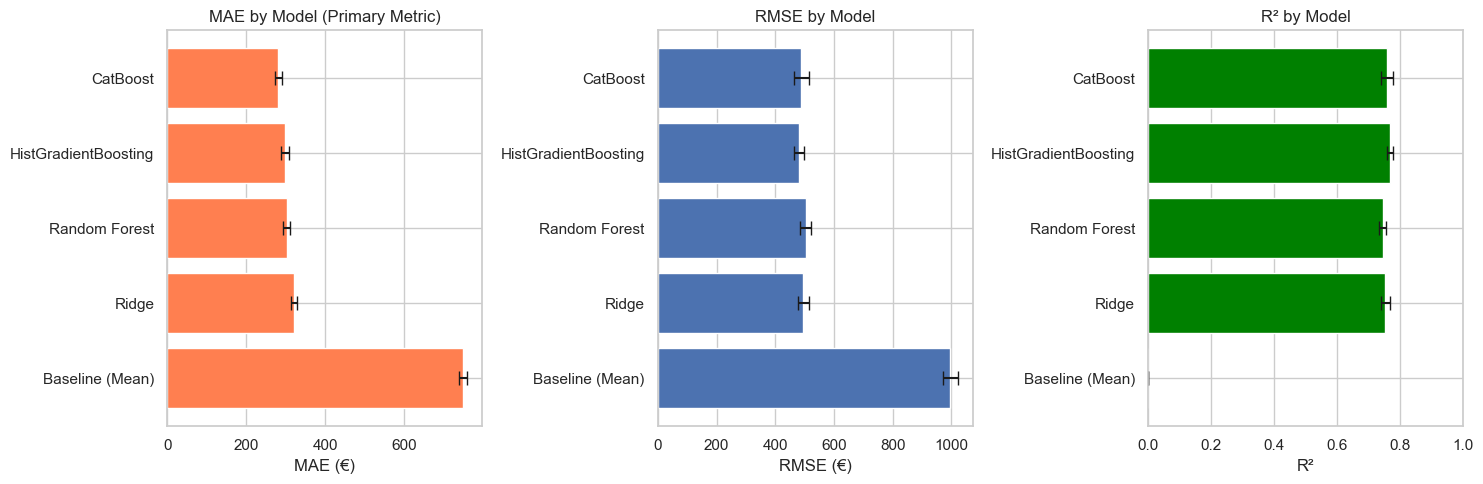

In [15]:
# Visualize comparison (MAE is primary metric)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE (primary metric - first)
ax = axes[0]
ax.barh(comparison['Model'], comparison['mae_mean'], xerr=comparison['mae_std'], capsize=5, color='coral')
ax.set_xlabel('MAE (€)')
ax.set_title('MAE by Model (Primary Metric)')
ax.invert_yaxis()

# RMSE
ax = axes[1]
ax.barh(comparison['Model'], comparison['rmse_mean'], xerr=comparison['rmse_std'], capsize=5)
ax.set_xlabel('RMSE (€)')
ax.set_title('RMSE by Model')
ax.invert_yaxis()

# R²
ax = axes[2]
ax.barh(comparison['Model'], comparison['r2_mean'], xerr=comparison['r2_std'], capsize=5, color='green')
ax.set_xlabel('R²')
ax.set_title('R² by Model')
ax.invert_yaxis()
ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

## 6. Train Best Model on Full Training Data

In [16]:
# Select best model based on MAE (primary metric)
best_model_name = comparison.iloc[0]['Model']
print(f"Best model (lowest MAE): {best_model_name}")

# Train on full training data
if best_model_name == 'CatBoost' and CATBOOST_AVAILABLE:
    # Train CatBoost
    final_model = build_catboost_model(categorical_cols, loss_function='MAE')  # Optimize for MAE
    final_model.fit(X_cb_train, y_cb_train)
    
    # Evaluate on test set
    y_pred = final_model.predict(X_cb_test)
    final_metrics = evaluate_predictions(y_cb_test, y_pred)
    
    # Feature columns for metadata
    model_feature_cols = list(X_cb.columns)
    
else:
    # Train sklearn model
    model_type_map = {
        'Random Forest': 'random_forest',
        'HistGradientBoosting': 'hist_gradient_boosting',
        'Ridge': 'ridge',
        'ElasticNet': 'elasticnet',
        'Baseline (Mean)': 'dummy'
    }
    model_type = model_type_map.get(best_model_name, 'random_forest')
    
    final_model = build_sklearn_pipeline(model_type, numeric_cols, categorical_cols)
    final_model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = final_model.predict(X_test)
    final_metrics = evaluate_predictions(y_test, y_pred)
    
    model_feature_cols = feature_cols

print(f"\nTest Set Performance:")
print(f"  MAE:  {final_metrics['mae']:,.2f} (primary)")
print(f"  RMSE: {final_metrics['rmse']:,.2f}")
print(f"  R²:   {final_metrics['r2']:.4f}")
print(f"  MAPE: {final_metrics['mape']:.2f}%")

Best model (lowest MAE): CatBoost

Test Set Performance:
  MAE:  251.85 (primary)
  RMSE: 435.99
  R²:   0.7942
  MAPE: 19.01%


## 7. Prediction Analysis

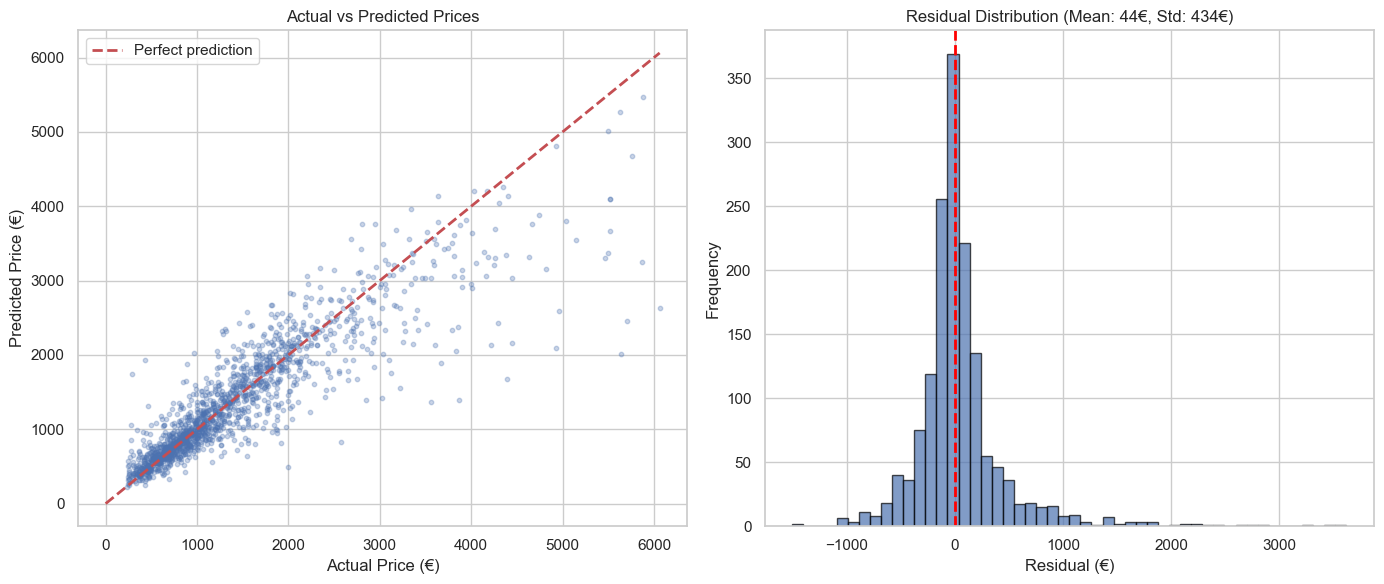

In [17]:
# Actual vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get the right y values
if best_model_name == 'CatBoost' and CATBOOST_AVAILABLE:
    y_actual = y_cb_test
else:
    y_actual = y_test

# Scatter plot
ax = axes[0]
ax.scatter(y_actual, y_pred, alpha=0.3, s=10)
ax.plot([0, y_actual.max()], [0, y_actual.max()], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Price (€)')
ax.set_ylabel('Predicted Price (€)')
ax.set_title('Actual vs Predicted Prices')
ax.legend()

# Residuals
ax = axes[1]
residuals = y_actual - y_pred
ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', lw=2)
ax.set_xlabel('Residual (€)')
ax.set_ylabel('Frequency')
ax.set_title(f'Residual Distribution (Mean: {residuals.mean():,.0f}€, Std: {residuals.std():,.0f}€)')

plt.tight_layout()
plt.show()

In [18]:
# Error by price range
results_df = pd.DataFrame({
    'actual': y_actual,
    'predicted': y_pred,
    'error': np.abs(y_actual - y_pred),
    'pct_error': np.abs(y_actual - y_pred) / y_actual * 100
})

# Price bins
results_df['price_bin'] = pd.cut(results_df['actual'], 
                                  bins=[0, 500, 1000, 1500, 2000, 3000, 10000],
                                  labels=['0-500', '500-1000', '1000-1500', '1500-2000', '2000-3000', '3000+'])

# Stats by price range
print("=== Error by Price Range ===")
error_by_range = results_df.groupby('price_bin', observed=True).agg({
    'actual': 'count',
    'error': ['mean', 'std'],
    'pct_error': 'mean'
}).round(2)
error_by_range.columns = ['Count', 'MAE (€)', 'Std (€)', 'MAPE (%)']
display(error_by_range)

=== Error by Price Range ===


,Count,MAE (€),Std (€),MAPE (%)
price_bin,,,,
0-500,161,148.33,211.60,40.75
500-1000,505,123.34,136.26,16.41
1000-1500,336,201.65,191.88,16.26
1500-2000,254,282.35,251.89,16.26
2000-3000,186,349.16,306.93,14.43
3000+,112,899.95,819.45,21.61


## 8. CatBoost Quantile Regression (Price Range Prediction)

In [19]:
if CATBOOST_AVAILABLE:
    print("=" * 60)
    print("QUANTILE REGRESSION (Price Range Prediction)")
    print("=" * 60)
    
    # Train models for different quantiles
    quantiles = [0.1, 0.5, 0.9]
    quantile_models = {}
    
    for q in quantiles:
        print(f"\nTraining quantile={q} model...")
        q_model = build_catboost_model(categorical_cols, loss_function='Quantile', quantile=q)
        q_model.fit(X_cb_train, y_cb_train)
        quantile_models[q] = q_model
    
    # Predict on test set
    pred_low = quantile_models[0.1].predict(X_cb_test)
    pred_mid = quantile_models[0.5].predict(X_cb_test)
    pred_high = quantile_models[0.9].predict(X_cb_test)
    
    # Check coverage
    in_range = (y_cb_test >= pred_low) & (y_cb_test <= pred_high)
    coverage = in_range.mean() * 100
    
    print(f"\n=== Quantile Prediction Results ===")
    print(f"Expected coverage (10%-90% interval): 80%")
    print(f"Actual coverage: {coverage:.1f}%")
    print(f"Average interval width: {(pred_high - pred_low).mean():,.0f}€")
else:
    print("CatBoost not available - skipping quantile regression")

QUANTILE REGRESSION (Price Range Prediction)

Training quantile=0.1 model...

Training quantile=0.5 model...

Training quantile=0.9 model...

=== Quantile Prediction Results ===
Expected coverage (10%-90% interval): 80%
Actual coverage: 69.2%
Average interval width: 721€


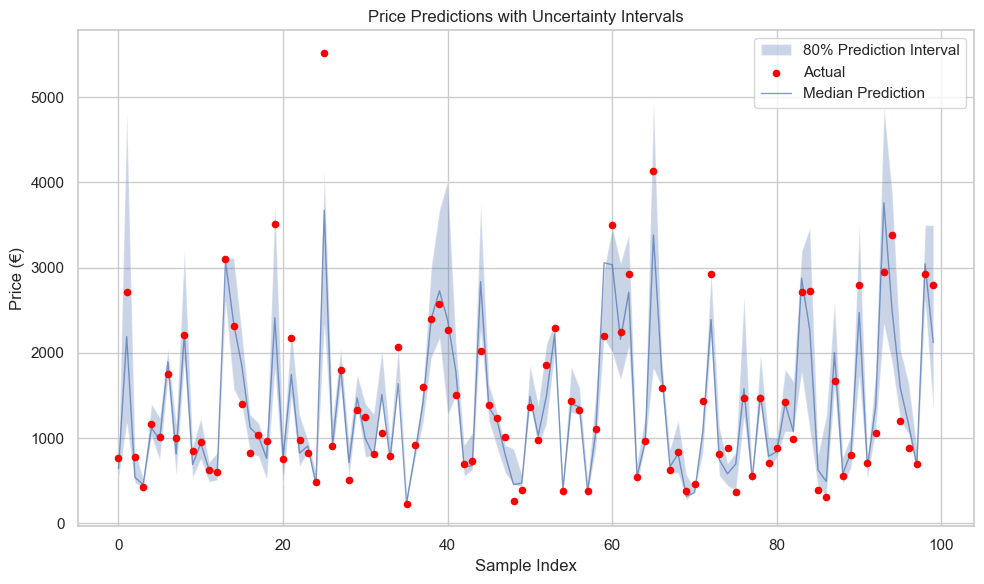

In [20]:
if CATBOOST_AVAILABLE:
    # Visualize quantile predictions
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Sample for visualization
    sample_idx = np.random.choice(len(y_cb_test), min(100, len(y_cb_test)), replace=False)
    sample_idx = np.sort(sample_idx)
    
    x_pos = np.arange(len(sample_idx))
    
    # Plot intervals (pred_low, pred_mid, pred_high are numpy arrays)
    ax.fill_between(x_pos, pred_low[sample_idx], pred_high[sample_idx], 
                    alpha=0.3, label='80% Prediction Interval')
    ax.scatter(x_pos, y_cb_test.iloc[sample_idx].values, c='red', s=20, label='Actual', zorder=5)
    ax.plot(x_pos, pred_mid[sample_idx], 'b-', lw=1, label='Median Prediction', alpha=0.7)
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Price (€)')
    ax.set_title('Price Predictions with Uncertainty Intervals')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 9. Save Best Model

In [21]:
# Save the best model with metadata
metadata = {
    'model_type': best_model_name,
    'feature_cols': model_feature_cols,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'target_col': TARGET_COL,
    'test_metrics': final_metrics,
    'cv_metrics': all_results.get(best_model_name, {}),
}

save_model(final_model, '../models/price_model.pkl', metadata)

print(f"\nModel saved with metadata:")
for key, value in metadata.items():
    if key in ['feature_cols', 'numeric_cols', 'categorical_cols']:
        print(f"  {key}: {len(value)} columns")
    else:
        print(f"  {key}: {value}")

Model saved to: ../models/price_model.pkl

Model saved with metadata:
  model_type: CatBoost
  feature_cols: 62 columns
  numeric_cols: 20 columns
  categorical_cols: 42 columns
  target_col: _precio_num
  test_metrics: {'rmse': 435.9904936208506, 'mae': 251.85299946491605, 'r2': 0.79420881439983, 'mape': 19.012233666040366}
  cv_metrics: {'mae_mean': 280.7868686428732, 'mae_std': 9.241873146425162, 'rmse_mean': 488.98009479897473, 'rmse_std': 24.75186419258385, 'r2_mean': 0.7586737371108504, 'r2_std': 0.019316670344052038}


## Summary

### Results

We trained and compared multiple models for predicting computer prices:

1. **Baseline** - Simple mean prediction
2. **Ridge Regression** - Linear model with L2 regularization
3. **Random Forest** - Ensemble of decision trees
4. **HistGradientBoosting** - sklearn's fast gradient boosting
5. **CatBoost** - Native categorical handling (if available)

### Evaluation Metrics (in order of importance)

1. **MAE (Mean Absolute Error)** - Primary metric, robust to outliers
2. **RMSE (Root Mean Squared Error)** - Penalizes large errors more
3. **R² (Coefficient of Determination)** - Explained variance
4. **MAPE (Mean Absolute Percentage Error)** - Relative error

### Data Preparation (from notebook 02)

- Features with >60% missing values removed before modeling
- CPU/GPU benchmarks matched using close neighbor + family mean imputation
- Complete benchmark features included:
  - CPU: `_cpu_mark`, `_cpu_rank`, `_cpu_value`, `_cpu_price_usd`
  - GPU: `_gpu_mark`, `_gpu_rank`, `_gpu_value`, `_gpu_price_usd`
- Excluded columns: `cpu_match_score`, `gpu_match_score`, `Ofertas`

### Key Findings

- Best model selected based on **lowest MAE** (most robust to outliers)
- Model saved to `models/price_model.pkl`
- Quantile regression enables price range predictions
- Error varies by price range (larger absolute errors for expensive items)

### Next Steps

1. Hyperparameter tuning optimizing for MAE (notebook 04)
2. Feature selection to reduce complexity
3. Deploy model via backend API